# Blog resources
- blog: https://towardsdatascience.com/quantum-machine-learning-learning-on-neural-networks-fdc03681aed3
- code: https://github.com/SashwatAnagolum/DoNew/tree/master/QNN

Adapted code from IRIS classification to sin curve regression

In [1]:
"""
qnn.py: a small quantum neural network that acts as a binary
classifier.
"""

from qiskit import QuantumRegister, ClassicalRegister
from qiskit import Aer, execute, QuantumCircuit
from qiskit.extensions import UnitaryGate
import numpy as np

In [2]:
def convertDataToAngles(data):
    """
    Takes in a normalised 4 dimensional vector and returns
    three angles such that the encodeData function returns
    a quantum state with the same amplitudes as the
    vector passed in.
    """
    prob1 = data[2] ** 2 + data[3] ** 2
    prob0 = 1 - prob1
    angle1 = 2 * np.arcsin(np.sqrt(prob1))
    prob1 = data[3] ** 2 / prob1
    angle2 = 2 * np.arcsin(np.sqrt(prob1))
    prob1 = data[1] ** 2 / prob0
    angle3 = 2 * np.arcsin(np.sqrt(prob1))
    return np.array([angle1, angle2, angle3])


def encodeData(qc, qreg, angles):
    """
    Given a quantum register belonging to a quantum
    circuit, performs a series of rotations and controlled
    rotations characterized by the angles parameter.
    """
#     qc.ry(angles[0], qreg[1])
    qc.ry(angles, qreg[1])

    # Comment out since we only have one angel
#     qc.cry(angles[1], qreg[1], qreg[0])
#     qc.x(qreg[1])
#     qc.cry(angles[2], qreg[1], qreg[0])
#     qc.x(qreg[1])

In [3]:
def GGate(qc, qreg, params):
    """
    Given a parameter α, return a single
    qubit gate of the form
    [cos(α), sin(α)]
    [-sin(α), cos(α)]
    """
    u00 = np.cos(params[0])
    u01 = np.sin(params[0])
    gateLabel = "G({})".format(
        params[0]
    )
    GGate = UnitaryGate(np.array(
        [[u00, u01], [-u01, u00]]
    ), label=gateLabel)
    return GGate


def GLayer(qc, qreg, params):
    """
    Applies a layer of UGates onto the qubits of register
    qreg in circuit qc, parametrized by angles params.
    """
    for i in range(2):
        qc.append(GGate(qc, qreg, params[i]), [qreg[i]])


def CGLayer(qc, qreg, anc, params):
    """
    Applies a controlled layer of UGates, all conditioned
    on the first qubit of the anc register.
    """
    for i in range(2):
        qc.append(GGate(
            qc, qreg, params[i]
        ).control(1), [anc[0], qreg[i]])


def CXLayer(qc, qreg, order):
    """
    Applies a layer of CX gates onto the qubits of register
    qreg in circuit qc, with the order of application
    determined by the value of the order parameter.
    """
    if order:
        qc.cx(qreg[0], qreg[1])
    else:
        qc.cx(qreg[1], qreg[0])


def CCXLayer(qc, qreg, anc, order):
    """
    Applies a layer of Toffoli gates with the first
    control qubit always being the first qubit of the anc
    register, and the second depending on the value
    passed into the order parameter.
    """
    if order:
        qc.ccx(anc[0], qreg[0], qreg[1])
    else:
        qc.ccx(anc[0], qreg[1], qreg[0])

In [4]:
def generateU(qc, qreg, params):
    """
    Applies the unitary U(θ) to qreg by composing multiple
    U layers and CX layers. The unitary is parametrized by
    the array passed into params.
    """
    for i in range(params.shape[0]):
        GLayer(qc, qreg, params[i])
        CXLayer(qc, qreg, i % 2)


def generateCU(qc, qreg, anc, params):
    """
    Applies a controlled version of the unitary U(θ),
    conditioned on the first qubit of register anc.
    """
    for i in range(params.shape[0]):
        CGLayer(qc, qreg, anc, params[i])
        CCXLayer(qc, qreg, anc, i % 2)

In [5]:
def getPrediction(qc, qreg, creg, backend):
    """
    Returns the probability of measuring the last qubit
    in register qreg as in the |1⟩ state.
    """
    qc.measure(qreg[0], creg[0])
    job = execute(qc, backend=backend, shots=1000)
    results = job.result().get_counts()
    if '1' in results.keys():
        return results['1'] / 1000
    else:
        return 0


def convertToClass(predictions):
    """
    Given a set of network outputs, returns class predictions
    by thresholding them.
    """
    return (predictions >= 0.5) * 1


def cost(labels, predictions):
    """
    Returns the sum of quadratic losses over the set
    (labels, predictions).
    """
    loss = 0
    for label, pred in zip(labels, predictions):
        loss += (pred - label) ** 2

    return loss / 2


def accuracy(labels, predictions):
    """
    Returns the percentage of correct predictions in the
    set (labels, predictions).
    """
    acc = 0
    for label, pred in zip(labels, predictions):
        if label == pred:
            acc += 1

    return acc / labels.shape[0]

In [6]:
def forwardPass(params, bias, angles, backend):
    """
    Given a parameter set params, input data in the form
    of angles, a bias, and a backend, performs a full
    forward pass on the network and returns the network
    output.
    """
    qreg = QuantumRegister(2)
    anc = QuantumRegister(1)
    creg = ClassicalRegister(1)
    qc = QuantumCircuit(qreg, anc, creg)
    encodeData(qc, qreg, angles)
    generateU(qc, qreg, params)
    pred = getPrediction(qc, qreg, creg, backend) + bias
    return 2 * (pred - 0.5)


def computeRealExpectation(params1, params2, angles, backend):
    """
    Computes the real part of the inner product of the
    quantum states produced by acting with U(θ)
    characterised by two sets of parameters, params1 and
    params2.
    """
    qreg = QuantumRegister(2)
    anc = QuantumRegister(1)
    creg = ClassicalRegister(1)
    qc = QuantumCircuit(qreg, anc, creg)
    encodeData(qc, qreg, angles)
    qc.h(anc[0])
    generateCU(qc, qreg, anc, params1)
    qc.cz(anc[0], qreg[0])
    qc.x(anc[0])
    generateCU(qc, qreg, anc, params2)
    qc.x(anc[0])
    qc.h(anc[0])
    prob = getPrediction(qc, anc, creg, backend)
    return 2 * (prob - 0.5)


def computeGradient(params, angles, label, bias, backend):
    """
    Given network parameters params, a bias bias, input data
    angles, and a backend, returns a gradient array holding
    partials with respect to every parameter in the array
    params.
    """
    prob = forwardPass(params, bias, angles, backend)
    gradients = np.zeros_like(params)
    for i in range(params.shape[0]):
        for j in range(params.shape[1]):
            newParams = np.copy(params)
            newParams[i, j, 0] += np.pi / 2
            gradients[i, j, 0] = computeRealExpectation(
                params, newParams, angles, backend
            )
            newParams[i, j, 0] -= np.pi / 2
    biasGrad = (prob + bias - label)
    return gradients * biasGrad, biasGrad


def updateParams(params, prevParams, grads, learningRate, momentum):
    """
    Updates the network parameters using gradient descent
    and momentum.
    """
    delta = params - prevParams
    paramsNew = np.copy(params)
    paramsNew = params - grads * learningRate + momentum * delta
    return paramsNew, params


def trainNetwork(data, labels, backend):
    """
    Train a quantum neural network on inputs data and
    labels, using backend backend. Returns the parameters
    learned.
    """
    np.random.seed(1)
    numSamples = labels.shape[0]
    numTrain = int(numSamples * 0.75)
    ordering = np.random.permutation(range(numSamples))
    # train and test on same data
#     trainingData = data[ordering[:numTrain]]
#     validationData = data[ordering[numTrain:]]
#     trainingLabels = labels[ordering[:numTrain]]
#     validationLabels = labels[ordering[numTrain:]]

    trainingData = data
    validationData = data
    trainingLabels = labels
    validationLabels = labels

    params = np.random.sample((5, 2, 1))
    bias = 0.01
    prevParams = np.copy(params)
    prevBias = bias
    batchSize = 5
    momentum = 0.9
    learningRate = 0.01
    epochs = 2
    
    for e in range(epochs):
        for iteration in range(10):
            samplePos = iteration * batchSize
            batchTrainingData = trainingData[samplePos:samplePos + batchSize]
            batchLabels = trainingLabels[samplePos:samplePos + batchSize]
            batchGrads = np.zeros_like(params)
            batchBiasGrad = 0
            for i in range(batchSize):
                grads, biasGrad = computeGradient(
                    params, batchTrainingData[i], batchLabels[i], bias, backend
                )
                batchGrads += grads / batchSize
                batchBiasGrad += biasGrad / batchSize

            params, prevParams = updateParams(
                params, prevParams, batchGrads, learningRate, momentum
            )

            temp = bias
            bias += -learningRate * batchBiasGrad + momentum * (bias - prevBias)
            prevBias = temp

            trainingPreds = np.array([forwardPass(
                params, bias, angles, backend
            ) for angles in trainingData])
            print('Iteration {} | Loss: {}'.format(
                iteration + 1, cost(trainingLabels, trainingPreds)
            ))

    validationProbs = np.array(
        [forwardPass(
            params, bias, angles, backend
        ) for angles in validationData]
    )
    # we just want the estimates
#     validationClasses = convertToClass(validationProbs)
    validationClasses = validationProbs
    
#     validationAcc = accuracy(validationLabels, validationClasses)
    mse = np.mean((validationLabels - validationClasses)**2)
    print('Validation MSE:', mse)
    for x, y, p in zip(validationData, validationLabels, validationClasses):
        print('X:', x, ' | Y:', y, ' | Prediction:', p)
        
    return(validationData, validationLabels, validationClasses)

In [7]:
data = np.genfromtxt("processedIRISData.csv", delimiter=",")
X = data[:, 0:4]
features = np.array([convertDataToAngles(i) for i in X])
Y = data[:, -1]
backend = Aer.get_backend('qasm_simulator')

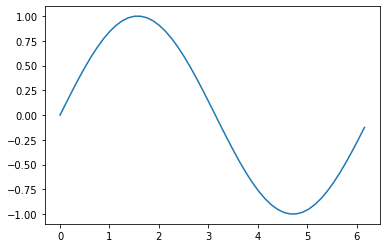

In [8]:
import math
import matplotlib.pyplot as plt
data_points = 50
sin_x = np.array([p for p in np.arange(0, 2*math.pi, (2*math.pi / data_points))])
sin_y = np.array([math.sin(a) for a in sin_x])
plt.plot(sin_x,sin_y);

In [9]:
len(sin_x)

50

In [10]:
X = sin_x
#Our data is already in angles so we don't need this line
# features = np.array([convertDataToAngles(i) for i in X])
Y = sin_y
backend = Aer.get_backend('qasm_simulator')

In [11]:
val_data, val_labels, val_preds = trainNetwork(X, Y, backend)

Iteration 1 | Loss: 17.82739939106074
Iteration 2 | Loss: 15.007900498447619
Iteration 3 | Loss: 11.896514246434034
Iteration 4 | Loss: 9.727299144304977
Iteration 5 | Loss: 7.30414258787579
Iteration 6 | Loss: 4.989535026409595
Iteration 7 | Loss: 2.699655102675547
Iteration 8 | Loss: 1.5898902583356576
Iteration 9 | Loss: 1.5559064193167857
Iteration 10 | Loss: 1.724280161547117
Iteration 1 | Loss: 2.0435988605997406
Iteration 2 | Loss: 2.396532380845156
Iteration 3 | Loss: 2.8952542879817993
Iteration 4 | Loss: 3.176684426005153
Iteration 5 | Loss: 2.748054199841476
Iteration 6 | Loss: 2.3200003649631893
Iteration 7 | Loss: 1.7715449371462084
Iteration 8 | Loss: 1.3630710867554092
Iteration 9 | Loss: 1.0653849113169915
Iteration 10 | Loss: 0.6642309620741983
Validation MSE: 0.028238794674918945
X: 0.0  | Y: 0.0  | Prediction: 0.10874714654413076
X: 0.12566370614359174  | Y: 0.12533323356430426  | Prediction: 0.3167471465441307
X: 0.25132741228718347  | Y: 0.2486898871648548  | Predi

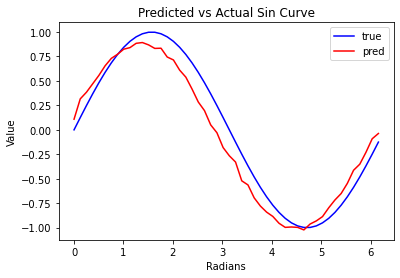

In [12]:
plt.plot(val_data, val_labels, c='blue', label='true')
plt.plot(val_data, val_preds, c='red', label='pred')
plt.title('Predicted vs Actual Sin Curve')
plt.ylabel('Value')
plt.xlabel('Radians')
plt.legend()